In [ ]:
import re
import json
import math
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mascaramos os caminhos do tipo C:\Users\NOME\... para não vazar usuário
def redact_path(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    return re.sub(r"(C:\\Users\\)([^\\]+)(\\)", r"\1<REDACTED>\3", s, flags=re.IGNORECASE)

# Nós removemos filename/lineno dos warnings para não vazar caminhos
def _formatwarning(message, category, filename, lineno, line=None):
    return f"{category.__name__}: {message}\n"

warnings.formatwarning = _formatwarning

# Nós silenciamos apenas o warning do Matplotlib que costuma imprimir caminhos/linhas
warnings.filterwarnings("ignore", message=r".*Tight layout not applied.*", category=UserWarning)

In [2]:
DATA_PATH = Path(r"C:\Users\willgnnerferreira\Documents\Modelos\Classificando-Perfil-de-Conciliação\Conciliação\dados\cejusc_14052025\dados_processos_cejusc_14052025.json")

def load_records(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {redact_path(path)}")

    text = path.read_text(encoding="utf-8", errors="replace").lstrip("\ufeff").strip()

    # 1) Nós tentamos JSON padrão (lista ou dict)
    try:
        data = json.loads(text)
        if isinstance(data, dict) and "data" in data and isinstance(data["data"], list):
            return data["data"]
        if isinstance(data, list):
            return data
        if isinstance(data, dict):
            return [data]
    except json.JSONDecodeError:
        pass

    # 2) Nós tentamos JSONL (1 JSON por linha)
    recs = []
    ok_jsonl = True
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            recs.append(json.loads(line))
        except json.JSONDecodeError:
            ok_jsonl = False
            break
    if ok_jsonl and recs:
        return recs

    # 3) Nós tentamos objetos JSON concatenados (sem estar linha a linha)
    decoder = json.JSONDecoder()
    idx = 0
    n = len(text)
    recs = []
    while idx < n:
        while idx < n and text[idx].isspace():
            idx += 1
        if idx >= n:
            break
        obj, end = decoder.raw_decode(text, idx)
        recs.append(obj)
        idx = end

    if len(recs) == 1 and isinstance(recs[0], list):
        recs = recs[0]
    return recs

records = load_records(DATA_PATH)
df = pd.DataFrame.from_records(records)

print("File:", DATA_PATH.name)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head(3)

File: dados_processos_cejusc_14052025.json
Rows: 16584
Columns: ['numero_processo', 'comarca', 'serventia', 'assunto', 'classe', 'polo_ativo', 'polo_passivo', 'cpf_cnpj_polo_ativo', 'cpf_cnpj_polo_passivo', 'inteiro_teor', 'codg_cnj_audi', 'codg_cnj_julgamento', 'classificacao']


,numero_processo,comarca,serventia,assunto,classe,polo_ativo,polo_passivo,cpf_cnpj_polo_ativo,cpf_cnpj_polo_passivo,inteiro_teor,codg_cnj_audi,codg_cnj_julgamento,classificacao
0,numero_processo,comarca,serventia,assunto,classe,polo_ativo,polo_passivo,cpf_cnpj_polo_ativo,cpf_cnpj_polo_passivo,inteiro_teor,NaN,NaN,classificacao
1,5437274.43.2024.8.09.0012,APARECIDA DE GOIÂNIA,Aparecida de Goiânia - 2º Juizado Especial Cível,DIREITO CIVIL -> Obrigações -> Espécies de Con...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Ex...,Lygia Crysthina Athaide Leite,Paulo Cesar Ribeiro De Oliveira,2132932506,11915791740,>>>>>inicio<<<<< AO JUIZO DO JUIZADO ESPECIAL ...,NaN,14099.0,frutifero
2,5437284.21.2024.8.09.0131,PORANGATU,Porangatu - Juizado Especial Cível,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DI...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Vilmar Alves Da Silva,Banco Itau Consignado Sa,24219452168,33885724000119,">>>>>inicio<<<<< Rua 02, nº 23, Qd. 18, Lt. 08...",12740.0,NaN,infrutifero


In [ ]:
print("Shape:", df.shape)

dup_rows = int(df.duplicated().sum())
print("Duplicate rows:", dup_rows)

if "numero_processo" in df.columns:
    print("Duplicate numero_processo:", int(df["numero_processo"].duplicated().sum()))

null_pct = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
print("\nTop null% columns:")
print(null_pct.head(20).to_string())

Shape: (16584, 13)
Duplicate rows: 0
Duplicate numero_processo: 0

Top null% columns:
codg_cnj_julgamento      53.82
codg_cnj_audi            12.93
polo_passivo              0.74
cpf_cnpj_polo_passivo     0.74
cpf_cnpj_polo_ativo       0.01
polo_ativo                0.01
classe                    0.00
serventia                 0.00
comarca                   0.00
numero_processo           0.00
assunto                   0.00
inteiro_teor              0.00
classificacao             0.00


In [4]:
TEXT_CANDIDATES = [
    "inteiro_teor_limpo", "inteiro_teor", "texto", "conteudo", "peticao", "descricao", "ementa",
    "assunto", "classe", "movimento",
    "comarca", "serventia"
]

text_cols = [c for c in TEXT_CANDIDATES if c in df.columns]
print("Text columns found:", text_cols)

if not text_cols:
    raise ValueError("Nós não encontramos colunas textuais candidatas. Ajustamos TEXT_CANDIDATES.")

CONFIG = {
    "use_lower": True,
    "keep_numbers": True,
    "min_token_len": 2,
    "top_k": 25,
    "zipf_head": 5000,
    "vocab_growth_limit_docs": 5000
}

def normalize_text(s: str, use_lower=True) -> str:
    if s is None:
        return ""
    s = str(s)
    s = s.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    s = re.sub(r"\s+", " ", s).strip()
    if use_lower:
        s = s.lower()
    return s

def tokenize(text: str, keep_numbers=True, min_token_len=2):
    text = normalize_text(text, CONFIG["use_lower"])
    if keep_numbers:
        toks = re.findall(r"[a-zà-ÿ0-9]+", text, flags=re.IGNORECASE)
    else:
        toks = re.findall(r"[a-zà-ÿ]+", text, flags=re.IGNORECASE)
    toks = [t for t in toks if len(t) >= min_token_len]
    return toks

Text columns found: ['inteiro_teor', 'assunto', 'classe', 'comarca', 'serventia']


In [5]:
def safe_log(x: float) -> float:
    return math.log(x) if x and x > 0 else float("nan")

def shannon_entropy(counter: Counter) -> float:
    total = sum(counter.values())
    if total == 0:
        return float("nan")
    ent = 0.0
    for c in counter.values():
        p = c / total
        ent -= p * math.log2(p)
    return ent

def analyze_column(series: pd.Series, colname: str):
    series = series.fillna("").astype(str)

    toks_per_doc = []
    chars_per_doc = []
    global_counter = Counter()

    numeric_tokens = 0
    total_token_chars = 0

    for txt in series.tolist():
        txtn = normalize_text(txt, CONFIG["use_lower"])
        chars_per_doc.append(len(txtn))

        toks = tokenize(txtn, CONFIG["keep_numbers"], CONFIG["min_token_len"])
        toks_per_doc.append(len(toks))
        global_counter.update(toks)

        for t in toks:
            total_token_chars += len(t)
            if t.isdigit():
                numeric_tokens += 1

    toks_per_doc = np.array(toks_per_doc, dtype=np.int64)
    chars_per_doc = np.array(chars_per_doc, dtype=np.int64)

    N_docs = int(len(toks_per_doc))
    N_tokens = int(toks_per_doc.sum())
    V_vocab = int(len(global_counter))

    ttr = (V_vocab / N_tokens) if N_tokens > 0 else float("nan")
    herdan_c = (safe_log(V_vocab) / safe_log(N_tokens)) if N_tokens > 1 and V_vocab > 1 else float("nan")

    hapax = sum(1 for _, c in global_counter.items() if c == 1)
    hapax_rate = (hapax / V_vocab) if V_vocab > 0 else float("nan")

    entropy = shannon_entropy(global_counter)
    pct_numeric = (numeric_tokens / N_tokens) if N_tokens > 0 else float("nan")
    avg_token_len = (total_token_chars / N_tokens) if N_tokens > 0 else float("nan")

    summary = {
        "column": colname,
        "docs": N_docs,
        "tokens_total": N_tokens,
        "vocab_types": V_vocab,
        "tokens_mean": float(np.mean(toks_per_doc)) if N_docs else float("nan"),
        "tokens_median": float(np.median(toks_per_doc)) if N_docs else float("nan"),
        "tokens_p95": float(np.quantile(toks_per_doc, 0.95)) if N_docs else float("nan"),
        "docs_tokens_zero": int(np.sum(toks_per_doc == 0)),
        "chars_mean": float(np.mean(chars_per_doc)) if N_docs else float("nan"),
        "chars_p95": float(np.quantile(chars_per_doc, 0.95)) if N_docs else float("nan"),
        "TTR": float(ttr),
        "Herdan_C": float(herdan_c),
        "hapax": int(hapax),
        "hapax_rate": float(hapax_rate),
        "shannon_entropy": float(entropy),
        "pct_numeric_tokens": float(pct_numeric),
        "avg_token_length": float(avg_token_len),
    }

    top_tokens = pd.DataFrame(global_counter.most_common(CONFIG["top_k"]), columns=["token", "freq"])

    # Zipf (rank x freq)
    freqs = np.array(sorted(global_counter.values(), reverse=True), dtype=np.int64)
    ranks = np.arange(1, len(freqs) + 1, dtype=np.int64)
    zipf_df = pd.DataFrame({"rank": ranks, "freq": freqs})

    # Vocabulary growth (subset)
    running = Counter()
    growth = []
    limit = min(N_docs, CONFIG["vocab_growth_limit_docs"])
    for txt in series.iloc[:limit].tolist():
        running.update(tokenize(txt, CONFIG["keep_numbers"], CONFIG["min_token_len"]))
        growth.append(len(running))
    growth_df = pd.DataFrame({"doc_idx": np.arange(1, len(growth) + 1), "vocab_size": growth})

    # Outliers por tokens (top 10 docs)
    outlier_idx = np.argsort(-toks_per_doc)[:10]
    outliers = pd.DataFrame({
        "row_index": outlier_idx,
        "n_tokens": toks_per_doc[outlier_idx],
        "n_chars": chars_per_doc[outlier_idx],
    })

    if "numero_processo" in df.columns:
        outliers["numero_processo"] = df.iloc[outlier_idx]["numero_processo"].astype(str).values

    return summary, toks_per_doc, top_tokens, zipf_df, growth_df, outliers

In [6]:
summaries = []
artifacts = {}

for col in text_cols:
    summary, toks, top_tokens, zipf_df, growth_df, outliers = analyze_column(df[col], col)
    summaries.append(summary)
    artifacts[col] = {
        "toks": toks,
        "top_tokens": top_tokens,
        "zipf": zipf_df,
        "growth": growth_df,
        "outliers": outliers
    }

summary_df = pd.DataFrame(summaries).sort_values("tokens_total", ascending=False)

print("\n=== Summary (per column) ===")
print(summary_df.to_string(index=False))

for col in text_cols:
    print("\n" + "="*100)
    print(f"TOP TOKENS — {col}")
    print(artifacts[col]["top_tokens"].to_string(index=False))

    print("\nOUTLIERS (top 10 docs by token count) —", col)
    print(artifacts[col]["outliers"].to_string(index=False))


=== Summary (per column) ===
      column  docs  tokens_total  vocab_types  tokens_mean  tokens_median  tokens_p95  docs_tokens_zero   chars_mean  chars_p95      TTR  Herdan_C  hapax  hapax_rate  shannon_entropy  pct_numeric_tokens  avg_token_length
inteiro_teor 16584      32128977       284249  1937.347865         1436.0      4724.1                 0 13575.888808   33237.40 0.008847  0.726492 149842    0.527150        11.154840            0.114872          5.388700
      classe 16584        243560          226    14.686445           15.0        19.0                 0   127.909129     190.00 0.000928  0.437030     41    0.181416         4.100467            0.001749          7.035158
     assunto 16584        186678          811    11.256512           10.0        21.0                 0    98.857754     179.85 0.004344  0.551882    159    0.196054         6.138473            0.005657          6.905591
   serventia 16584         84191          247     5.076640            5.0         7.0 

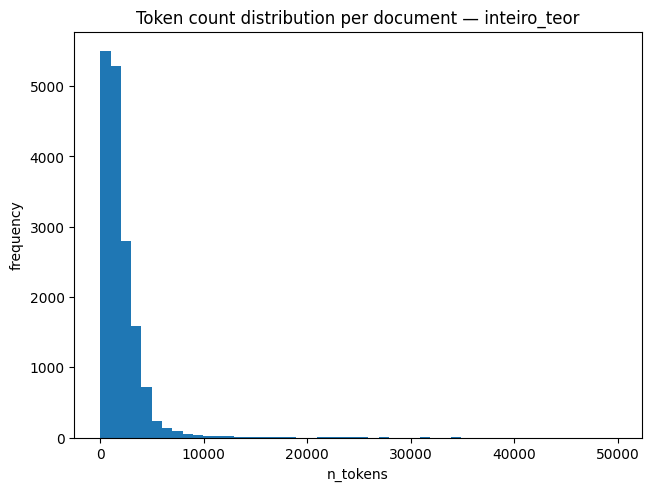

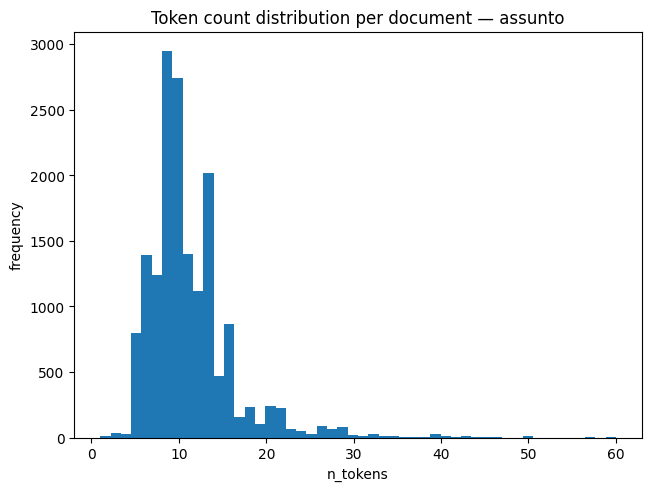

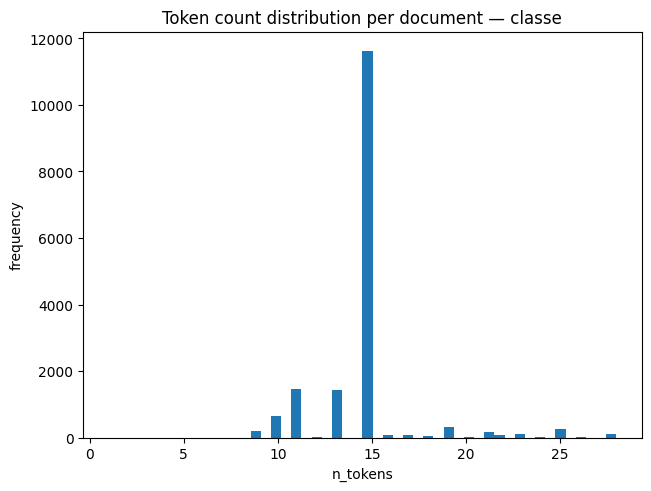

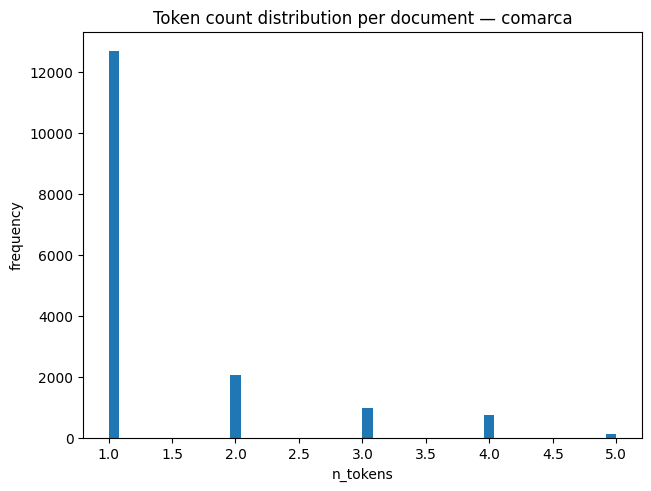

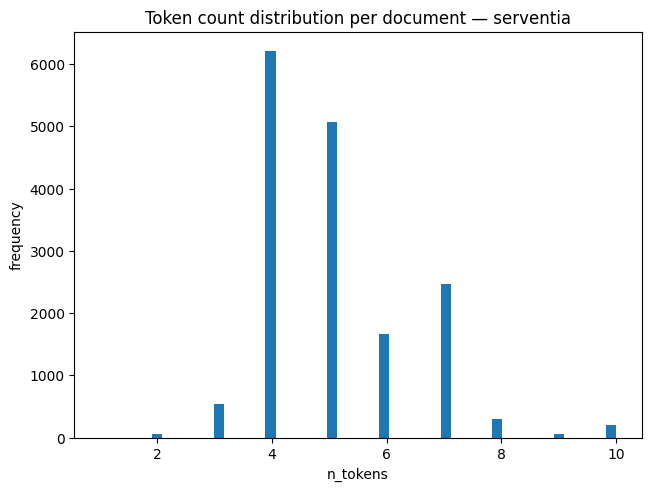

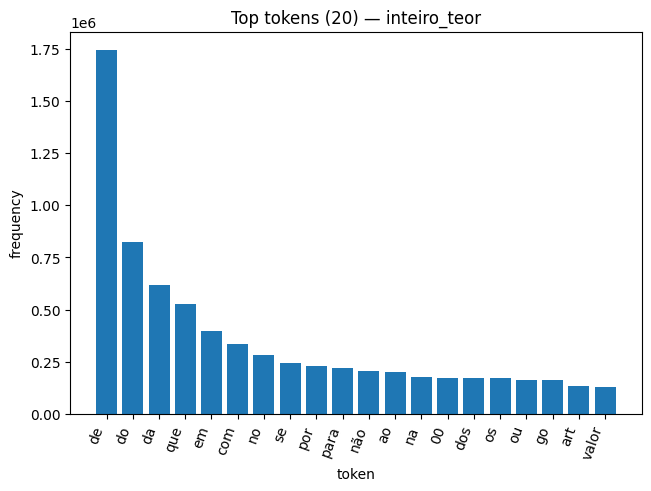

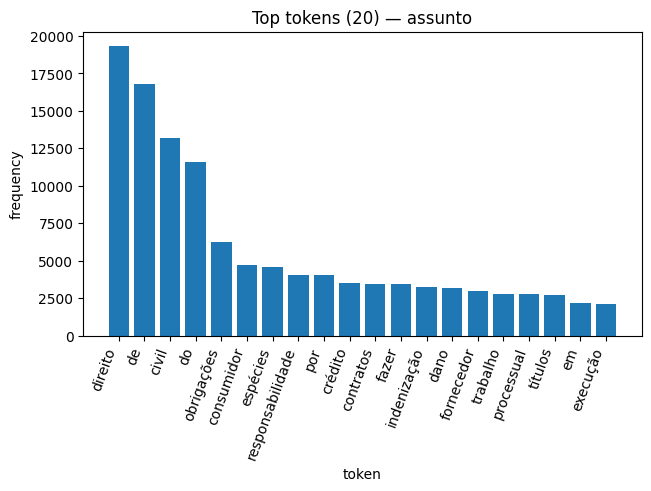

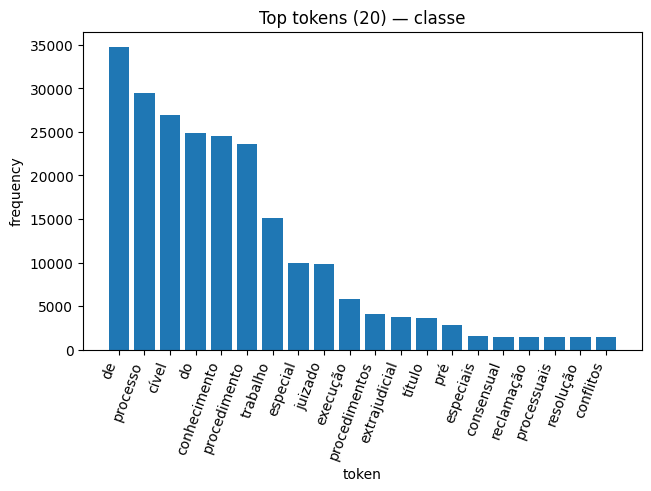

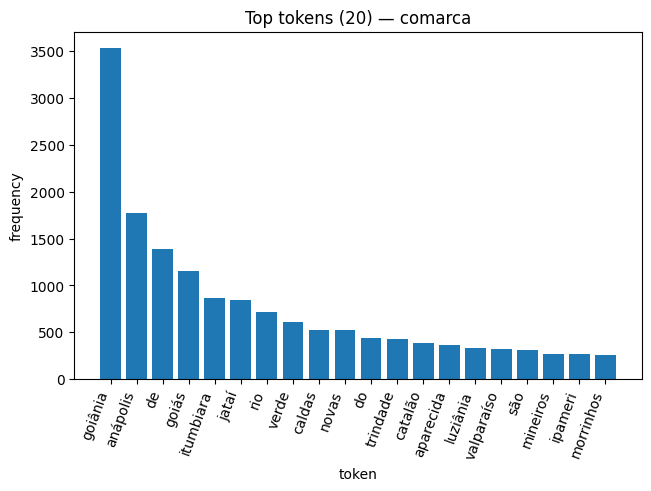

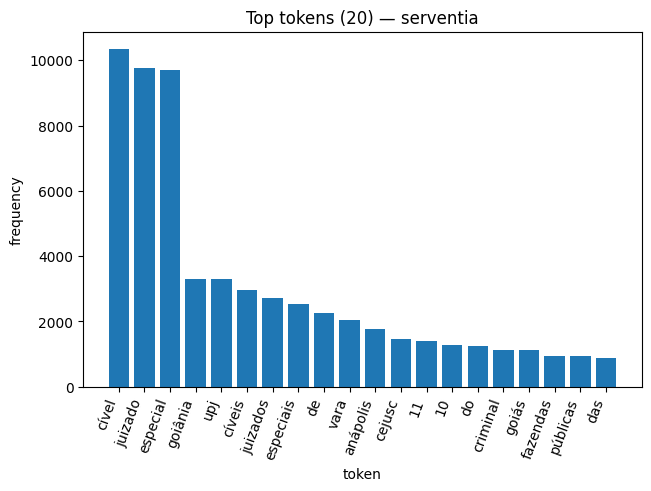

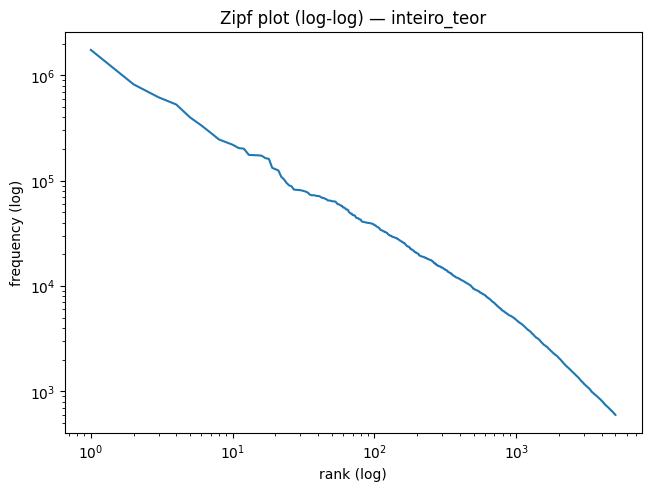

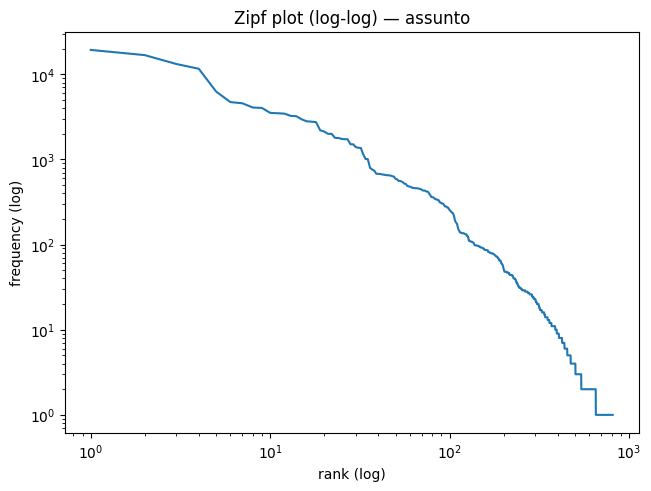

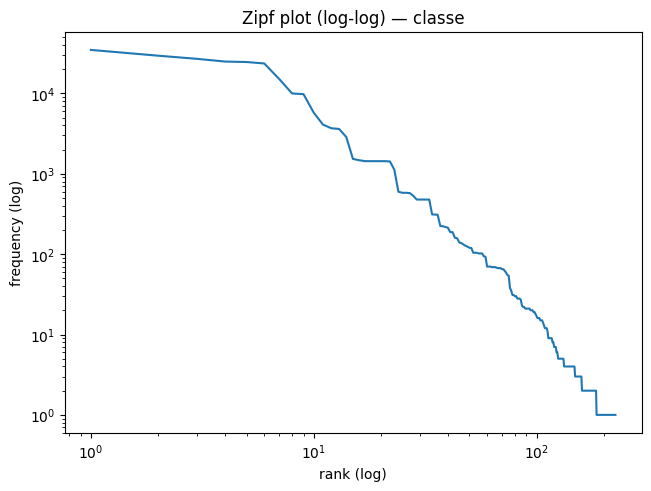

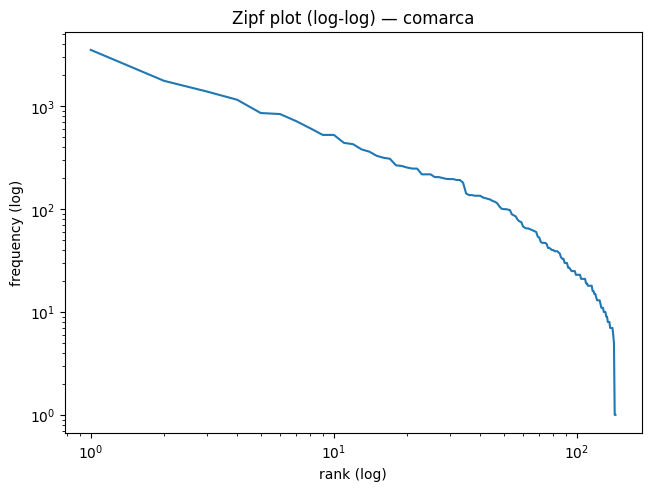

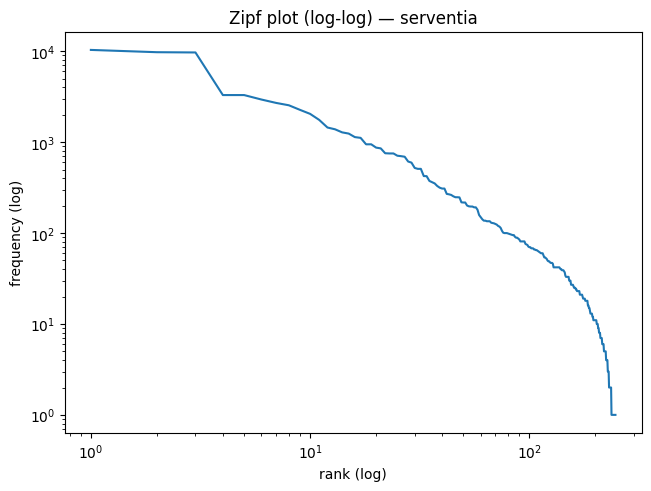

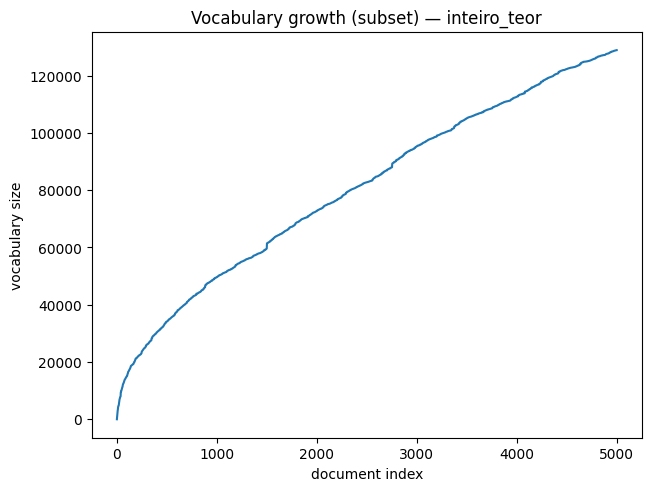

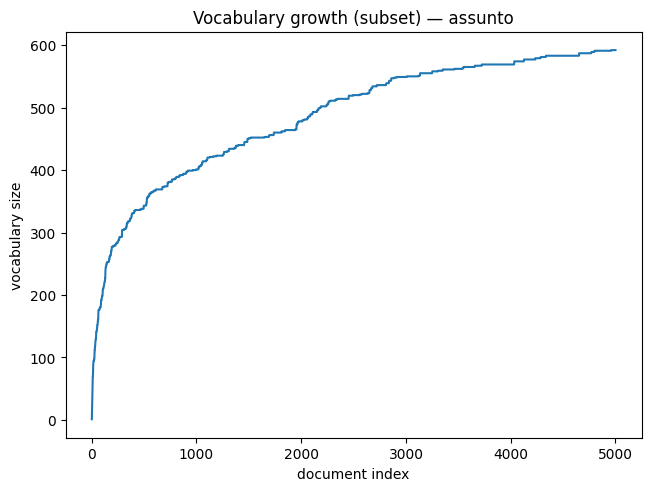

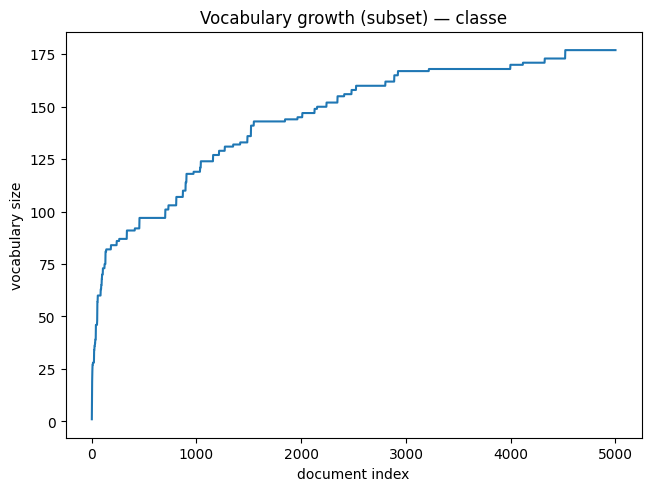

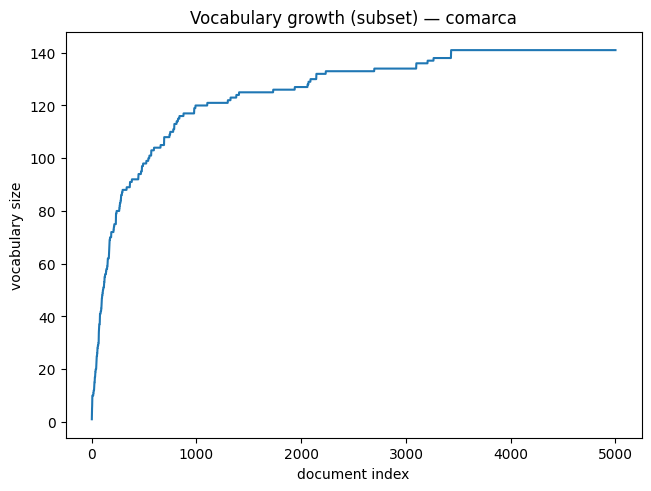

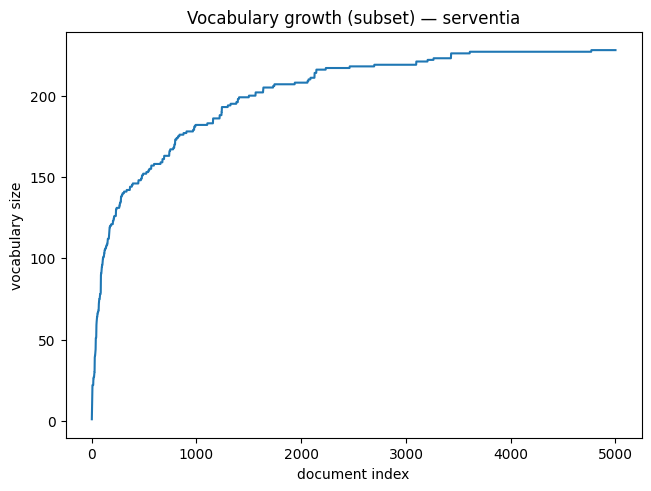

In [7]:
for col in text_cols:
    toks = artifacts[col]["toks"]

    plt.figure(constrained_layout=True)
    plt.hist(toks, bins=50)
    plt.title(f"Token count distribution per document — {col}")
    plt.xlabel("n_tokens")
    plt.ylabel("frequency")
    plt.show()

for col in text_cols:
    top_df = artifacts[col]["top_tokens"].head(20)

    plt.figure(constrained_layout=True)
    plt.bar(top_df["token"], top_df["freq"])
    plt.title(f"Top tokens (20) — {col}")
    plt.xlabel("token")
    plt.ylabel("frequency")
    plt.xticks(rotation=70, ha="right")
    plt.show()

for col in text_cols:
    zipf_df = artifacts[col]["zipf"].head(CONFIG["zipf_head"])

    plt.figure(constrained_layout=True)
    plt.plot(zipf_df["rank"], zipf_df["freq"])
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"Zipf plot (log-log) — {col}")
    plt.xlabel("rank (log)")
    plt.ylabel("frequency (log)")
    plt.show()

for col in text_cols:
    growth_df = artifacts[col]["growth"]

    plt.figure(constrained_layout=True)
    plt.plot(growth_df["doc_idx"], growth_df["vocab_size"])
    plt.title(f"Vocabulary growth (subset) — {col}")
    plt.xlabel("document index")
    plt.ylabel("vocabulary size")
    plt.show()


TOP VALUES (30) — comarca
                      value  frequency
                    GOIÂNIA       3171
                   ANÁPOLIS       1769
                  ITUMBIARA        860
                      JATAÍ        841
                  RIO VERDE        611
               CALDAS NOVAS        527
                   TRINDADE        428
                    CATALÃO        381
       APARECIDA DE GOIÂNIA        362
                   LUZIÂNIA        330
        VALPARAÍSO DE GOIÁS        316
                      GOIÁS        295
                   MINEIROS        267
                    IPAMERI        263
                  MORRINHOS        254
             SENADOR CANEDO        248
           CIDADE OCIDENTAL        218
               QUIRINÓPOLIS        218
                    FORMOSA        205
                  PORANGATU        205
                  GOIANÉSIA        201
      ÁGUAS LINDAS DE GOIÁS        196
                  NOVO GAMA        192
      SANTA HELENA DE GOIÁS        14

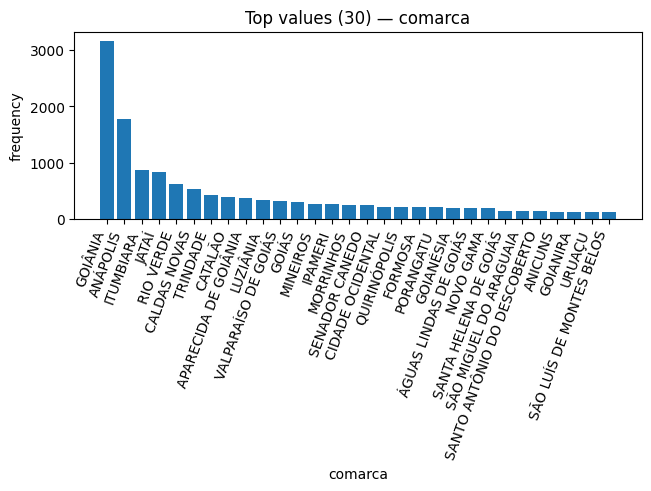


TOP VALUES (30) — serventia
                                                                value  frequency
Goiânia - 2ª UPJ Juizados Especiais Cíveis: 6º, 7º, 8º, 9º, 10º e 11º       1213
      Goiânia - 1ª UPJ Juizados Especiais Cíveis: 1º, 2º, 3º, 4º e 5º        849
                                 Anápolis - 3º Juizado Especial Cível        504
                     Itumbiara - 1º Juizado Especial Cível e Criminal        417
                                 Anápolis - 2º Juizado Especial Cível        416
                                 Anápolis - 4º Juizado Especial Cível        415
                                       Jataí - Juizado Especial Cível        404
                     Itumbiara - 2º Juizado Especial Cível e Criminal        391
                                    Trindade - Juizado Especial Cível        336
                    Catalão - UPJ Juizados Especiais Cíveis - 1º e 2º        330
                               6º CEJUSC REGIONAL VIRTUAL DO INTERIOR        320

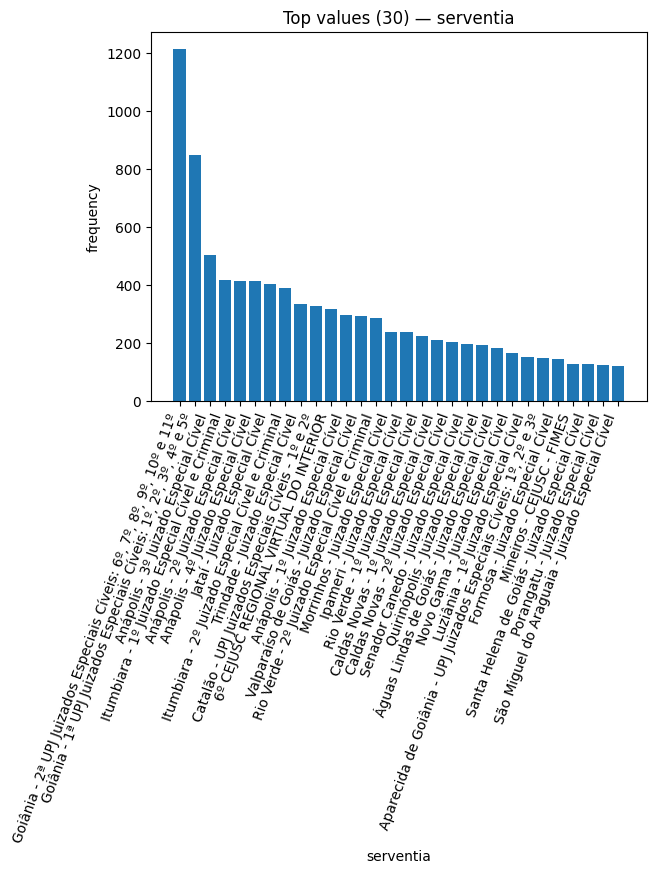


TOP VALUES (30) — assunto
                                                                                                                                                                              value  frequency
                                                                                                  DIREITO CIVIL -> Obrigações -> Espécies de Títulos de Crédito -> Nota Promissória       1598
                                                                    DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liquidação / Cumprimento / Execução -> Obrigação de Fazer / Não Fazer       1574
                                                                                           DIREITO DO CONSUMIDOR -> Responsabilidade do Fornecedor -> Indenização por Dano Material        743
                                                                                                      DIREITO CIVIL -> Obrigações -> Espécies de Contratos -> Prestação de Serviços        562
                  

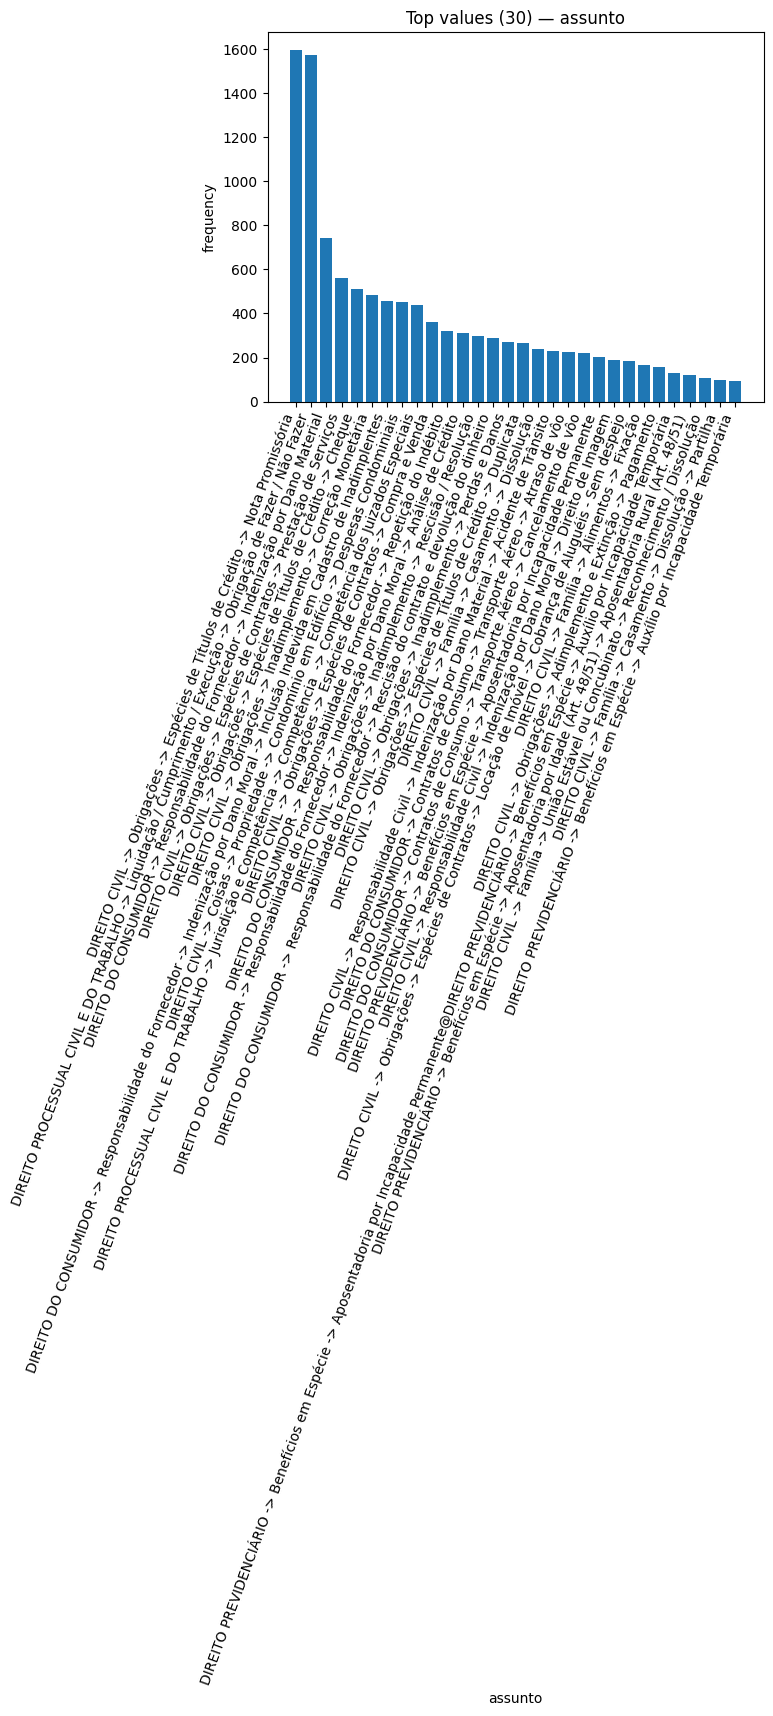

In [8]:
cat_cols = [c for c in ["comarca", "serventia", "assunto"] if c in df.columns]

for c in cat_cols:
    vc = df[c].fillna("NA").astype(str).value_counts().head(30)

    print("\n" + "="*100)
    print(f"TOP VALUES (30) — {c}")
    print(pd.DataFrame({"value": vc.index, "frequency": vc.values}).to_string(index=False))

    plt.figure(constrained_layout=True)
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top values (30) — {c}")
    plt.xlabel(c)
    plt.ylabel("frequency")
    plt.xticks(rotation=70, ha="right")
    plt.show()